# EDA - Datos TCA


### Librerías

In [1]:
import sys
print(sys.executable)


C:\Users\Owner\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe


In [2]:
!python -m venv myenv

Error: [Errno 13] Permission denied: 'c:\\Users\\Owner\\Desktop\\datos_tca\\myenv\\Scripts\\python.exe'


In [3]:
!myenv\Scripts\activate.bat

In [9]:
!pip uninstall numpy pandas matplotlib seaborn tensorflow -y

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: matplotlib 3.9.2
Uninstalling matplotlib-3.9.2:
  Successfully uninstalled matplotlib-3.9.2
Found existing installation: seaborn 0.13.2
Uninstalling seaborn-0.13.2:
  Successfully uninstalled seaborn-0.13.2


You can safely remove it manually.
You can safely remove it manually.
You can safely remove it manually.
You can safely remove it manually.
You can safely remove it manually.


In [5]:
!pip install numpy pandas matplotlib seaborn tensorflow --user

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl (390.3 MB)


In [4]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#from sklearn.preprocessing import category_encoders
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
#from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
#sns.set_theme(style="darkgrid")

In [5]:
pd.set_option('display.max_columns', None)

### Conexión a SQL

In [6]:
host = "localhost"  # e.g., 'localhost' or IP address
port = "5432"       # default PostgreSQL port
database = "postgres"
user = "postgres"
password = "equipo3"


In [7]:
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")
#connection = engine.connect()


### Creación de dataframes

In [8]:
df_ocup = pd.read_sql(f"SELECT * FROM ocupaciones", engine)


threshold_zero = 0.9

df_ocup = df_ocup.loc[:, (df_ocup == 0).mean() < threshold_zero]
# Replace empty strings with NaN
df_ocup = df_ocup.replace(r"^\s*$", np.nan, regex=True)



#### Tabla Reservaciones

Contiene detalles de diferentes reservaciones en un periodo de tiempo.

In [9]:
df_resv = pd.read_sql(f"SELECT * FROM reservaciones", engine, index_col='id_reserva')
threshold_zero = 0.9

#df_resv = df_resv.loc[:, (df_resv == 0).mean() < threshold_zero]
# Replace empty strings with NaN
df_resv = df_resv.replace(r"^\s*$", np.nan, regex=True)

## Estandarizar fechas

In [10]:
def standardize_date(date_column):
    # Convert column to string to handle different formats
    date_column = date_column.astype(str)
    
    # Convert to datetime: auto-parse for common formats
    date_column = pd.to_datetime(date_column, format=None, errors='coerce')
    
    # Format the column to remove the time part
    return date_column.dt.strftime('%Y-%m-%d')


In [11]:
# Apply the standardization function
df_resv['fecha_hoy'] = standardize_date(df_resv['fecha_hoy'])
df_resv['h_res_fec'] = standardize_date(df_resv['h_res_fec'])
df_resv['h_res_fec_ok'] = standardize_date(df_resv['h_res_fec_ok'])
df_resv['h_fec_lld_ok'] = standardize_date(df_resv['h_fec_lld_ok'])
df_resv['h_fec_reg_ok'] = standardize_date(df_resv['h_res_fec'])
df_resv['h_fec_sda_ok'] = standardize_date(df_resv['h_res_fec_ok'])
df_resv['h_ult_cam_fec_ok'] = standardize_date(df_resv['h_ult_cam_fec_ok'])
df_resv = df_resv.drop(columns=['h_res_fec_okt','h_fec_lld_okt',
                                'h_fec_reg_okt','h_fec_sda_okt',
                               'h_ult_cam_fec_okt'])

df_resv['h_fec_lld'] = df_resv['h_fec_lld'].fillna(0)
df_resv['h_fec_lld'] = df_resv['h_fec_lld'].astype(int).astype(str)

# Step 2: Convert to datetime format
df_resv['h_fec_lld'] = pd.to_datetime(df_resv['h_fec_lld'], format='%Y%m%d', errors='coerce')

# List of columns to convert
date_columns = ['h_res_fec', 'h_fec_sda_ok', 'h_ult_cam_fec_ok', 'fecha_hoy']

# Convert columns to datetime format
for col in date_columns:
    df_resv[col] = pd.to_datetime(df_resv[col], errors='coerce')

## Merge a datos originales de la reservacion

In [12]:
# Function to choose the original if changes were made
def original_if_changed(orig, changed):
    return changed if changed != 0 else orig

# Create new columns by combining original and changed values
for col in ['h_num_per', 'h_num_adu', 'h_num_men', 'h_num_noc', 'h_tot_hab','h_tfa_total','cliente_disp']:
    df_resv[f'{col}'] = df_resv.apply(lambda x: original_if_changed(x[col], x[f'aa_{col}']), axis=1)

# Display the updated DataFrame
#df_resv[['h_num_per', 'h_num_adu', 'h_num_men', 'h_num_noc', 'h_tot_hab']]

## ELIMINACION DE COLUMNAS QUE YA NO NOS SIRVEN

Diferentes columnas contienen la fecha u hora, así como repiten datos.

In [13]:
df_resv = df_resv.drop(columns=['h_nom','h_edo','aa_reservacion','aa_h_num_per','aa_h_num_adu','aa_h_num_men','aa_h_num_noc','aa_h_tot_hab','aa_h_tfa_total','aa_cliente_disp'])


df_resv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203002 entries, 0 to 203001
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   fecha_hoy                 203002 non-null  datetime64[ns]
 1   h_res_fec                 203002 non-null  datetime64[ns]
 2   h_res_fec_ok              203002 non-null  object        
 3   h_num_per                 203002 non-null  int64         
 4   h_num_adu                 203002 non-null  int64         
 5   h_num_men                 203002 non-null  int64         
 6   h_num_noc                 203002 non-null  int64         
 7   h_tot_hab                 203002 non-null  int64         
 8   id_programa               203002 non-null  int64         
 9   id_paquete                203002 non-null  int64         
 10  id_segmento_comp          203002 non-null  int64         
 11  id_agencia                203002 non-null  int64         
 12  id_empr

## fEATURE ENGINEERING

In [14]:
# Derived features
df_resv['days_to_arrival'] = (df_resv['h_fec_lld'] - df_resv['h_res_fec']).dt.days
df_resv['late_booking'] = (df_resv['days_to_arrival'] <= 3).astype(int)
df_resv['weekend_arrival'] = df_resv['h_fec_lld'].dt.weekday.isin([5, 6]).astype(int)

# Ensure the column is in datetime format
df_resv['h_res_fec'] = pd.to_datetime(df_resv['h_res_fec'], errors='coerce')

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_resv['reservation_day_of_week'] = df_resv['h_res_fec'].dt.dayofweek


In [15]:
import pandas as pd

# Sample data conversion, adapt column names and formats as necessary
df_resv['h_fec_lld_ok'] = pd.to_datetime(df_resv['h_fec_lld_ok'], errors='coerce')  # Use 'coerce' to handle any non-conformable values
df_resv['h_ult_cam_fec_ok'] = pd.to_datetime(df_resv['h_ult_cam_fec_ok'], errors='coerce')

# Calculate the difference in days between arrival and last change
df_resv['days_btwn_change_arrival'] = abs((df_resv['h_fec_lld_ok'] - df_resv['h_ult_cam_fec_ok']).dt.days)

# Create a binary target: 1 if days_between is 0, else 0 (you might have actual no-show data to use here)
df_resv['is_no_show'] = ((df_resv['days_btwn_change_arrival']==0) & (df_resv['reservacion']==0)).astype(int)



In [16]:
import pandas as pd

# Assuming 'arrival_date' is a datetime column in your dataframe
df_resv['month'] = df_resv['h_fec_lld'].dt.month
df_resv['week_of_year'] = df_resv['h_fec_lld'].dt.isocalendar().week
df_resv['advanced_booking'] = df_resv['days_to_arrival'] * df_resv['late_booking']
# Example: Mean days to arrival by room type
avg_days_by_room = df_resv.groupby('id_tipo_habitacion')['days_to_arrival'].mean().to_dict()
df_resv['avg_days_by_room_type'] = df_resv['id_tipo_habitacion'].map(avg_days_by_room)


In [19]:
# Assuming df_ocup and df_resv as your dataframes
df_resv = df_resv.rename(columns={'id_segmento_comp': 'ID_Segmento_Comp'})
df_resv = df_resv.rename(columns={'id_tipo_habitacion': 'ID_Tipo_Habitacion'})




# Calculate average ADR and TREVPEC for each competitive segment in 'Ocupaciones'
avg_metrics = df_ocup.groupby('ID_Segmento_Comp').agg({
    'ADR': 'mean',
    'TREVPEC': 'mean'
}).rename(columns={'ADR': 'avg_ADR_per_comp', 'TREVPEC': 'avg_TREVPEC_per_comp'})

# Merge these averages into 'Reservaciones'
df_resv = df_resv.merge(avg_metrics, on='ID_Segmento_Comp', how='left')

# Calculate average ADR by room type in 'Ocupaciones'
avg_adr_room = df_ocup.groupby('ID_Tipo_Habitacion')['ADR'].mean().rename('avg_ADR_per_room')

# Merge this average into 'Reservaciones'
df_resv = df_resv.merge(avg_adr_room, on='ID_Tipo_Habitacion', how='left')

# Now df_resv contains the new features which can be used for further classification model building.
#df_resv=df_resv.drop(['avg_ADR_per_comp_y','avg_TREVPEC_per_comp_y'], axis=1)
#df_resv = df_resv.rename(columns={'avg_ADR_per_comp_x': 'avg_ADR_per_comp'})
#df_resv = df_resv.rename(columns={'avg_TREVPEC_per_comp_x': 'avg_TREVPEC_per_comp'})

In [20]:
df_resv=df_resv.drop(['avg_TREVPEC_per_comp_y','avg_ADR_per_room_y','avg_ADR_per_comp_y'], axis=1)
df_resv = df_resv.rename(columns={'avg_ADR_per_comp_x': 'avg_ADR_per_comp'})
df_resv = df_resv.rename(columns={'avg_TREVPEC_per_comp_x': 'avg_TREVPEC_per_comp'})
df_resv = df_resv.rename(columns={'avg_ADR_per_room_x': 'avg_ADR_per_room'})

df_resv.head()

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,ID_Segmento_Comp,id_agencia,id_empresa,ID_Tipo_Habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,reservacion,id_estatus_reservaciones,h_tfa_total,moneda_cve,h_ult_cam_fec_ok,days_to_arrival,late_booking,weekend_arrival,reservation_day_of_week,days_btwn_change_arrival,is_no_show,month,week_of_year,advanced_booking,avg_days_by_room_type,avg_ADR_per_comp,avg_TREVPEC_per_comp,avg_ADR_per_room
0,2019-08-16,2019-08-16,2019-08-16,2,2,0,3,1,1,1,14,112,1,25,10,2019-11-07,2019-11-07,2019-08-16,2019-08-16,157,2,1,9,2659.98,1,2019-11-10,83.0,0,0,4,3,0,11.0,45,0.0,75.975638,681.213913,639.712705,790.636577
1,2019-10-22,2019-10-22,2019-10-22,4,4,0,4,1,1,2,14,112,1,25,10,2019-12-01,2019-12-01,2019-10-22,2019-10-22,157,4,1,9,1764.00,1,2019-12-05,40.0,0,1,1,4,0,12.0,48,0.0,75.975638,681.213913,639.712705,790.636577
2,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,14,112,1,23,10,2019-12-01,2019-12-01,2019-10-28,2019-10-28,157,2,1,9,2660.04,1,2019-12-05,34.0,0,1,0,4,0,12.0,48,0.0,77.265838,681.213913,639.712705,725.630026
3,2019-10-28,2019-10-28,2019-10-28,4,3,0,3,1,1,2,14,112,1,24,10,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,3,1,9,1995.03,1,2019-12-11,41.0,0,1,0,3,0,12.0,49,0.0,64.848012,681.213913,639.712705,727.018484
4,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,5,14,1,4,13,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,2,1,9,13369.92,1,2019-12-12,41.0,0,1,0,4,0,12.0,49,0.0,84.582809,720.893346,661.431288,895.168891


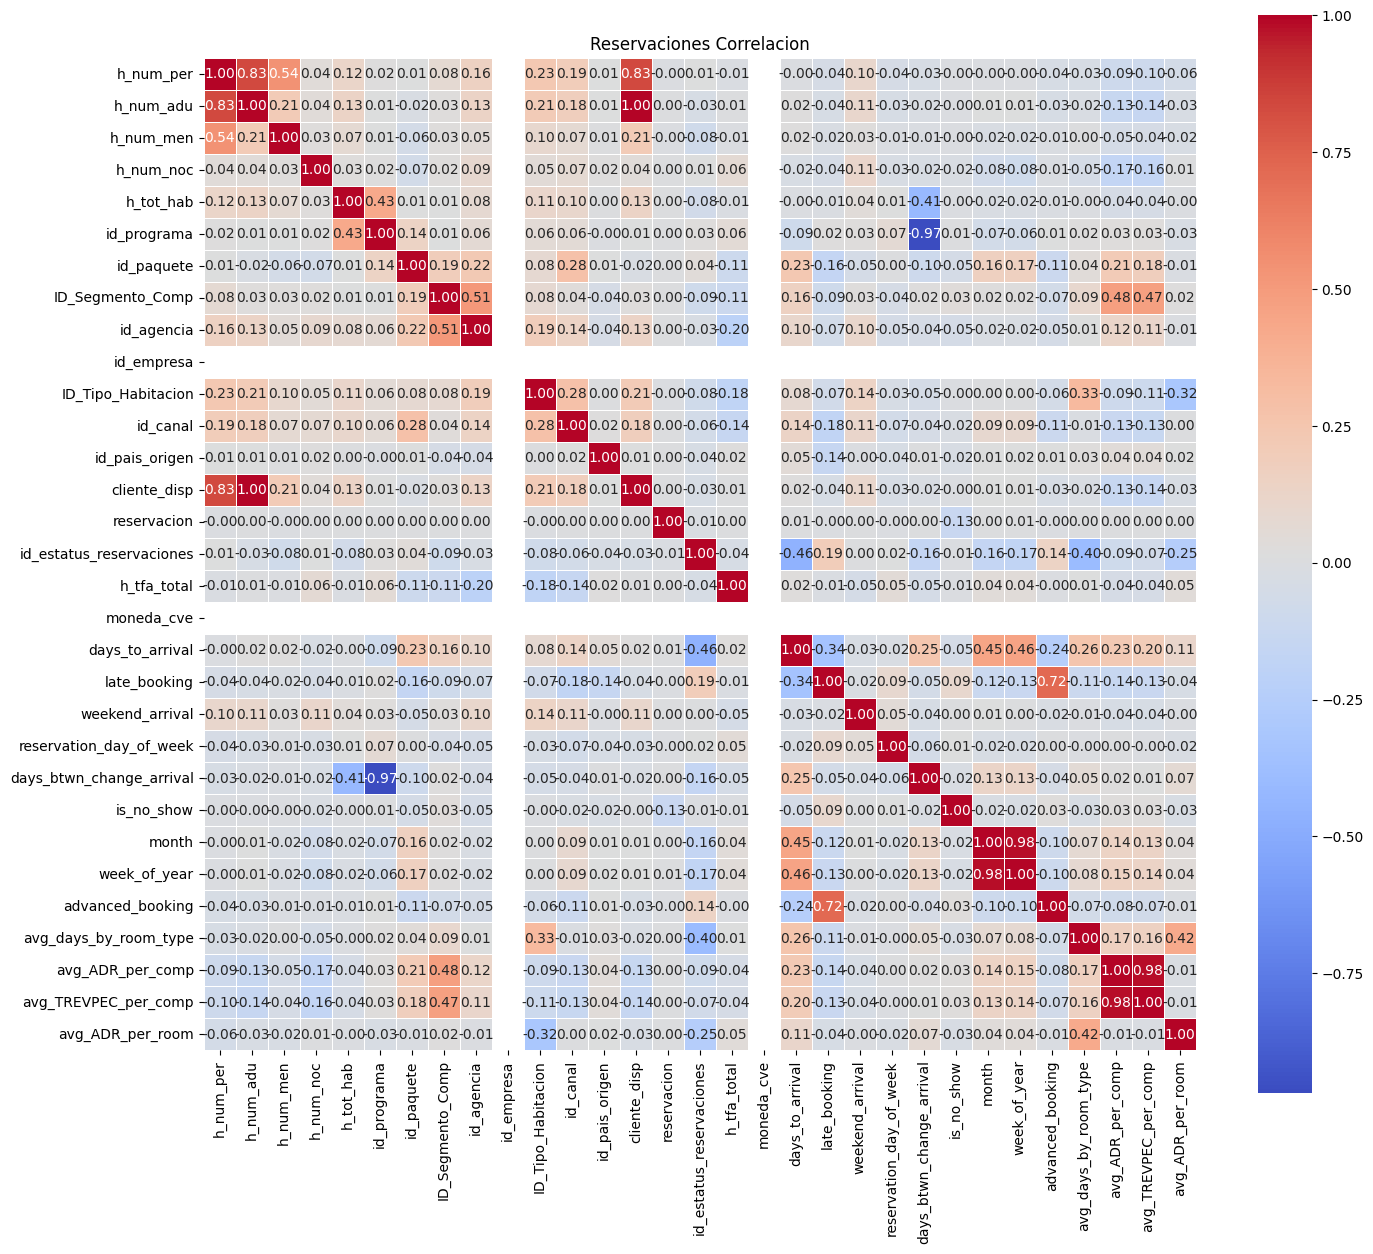

In [21]:
corr_resv = df_resv.corr(numeric_only=True)
plt.figure(figsize=(16, 14))
sns.heatmap(corr_resv, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Reservaciones Correlacion')
plt.show()

# MODELO

### random forest for best features

In [40]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Supongamos que df es tu DataFrame

# Mezclar los datos
df_reservaciones = shuffle(df_resv, random_state=42)
drop_columns=['days_btwn_change_arrival','reservacion',
              'is_no_show','fecha_hoy','h_res_fec','h_res_fec_ok','h_fec_lld','h_fec_lld_ok',
              'h_fec_reg_ok','h_fec_sda_ok','h_ult_cam_fec_ok']
# Dividir los datos en conjuntos de entrenamiento y prueba con estratificación
X = df_reservaciones.drop(drop_columns, axis=1)  # Asume que 'reservacion' es tu columna objetivo
y = df_reservaciones['is_no_show']
X = X.dropna()
y = y.loc[X.index]


In [41]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the undersampler
rus = RandomUnderSampler( random_state=42)

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the balance
print(pd.Series(y_resampled).value_counts())  # Outputs the counts of each class to confirm balance

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,  # This should match y_resampled
    random_state=42
)

# Verify class distribution in the train and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Test set class distribution:")
print(y_test.value_counts(normalize=True))

is_no_show
0    2167
1    2167
Name: count, dtype: int64
Training set class distribution:
is_no_show
1    0.500144
0    0.499856
Name: proportion, dtype: float64
Test set class distribution:
is_no_show
0    0.500577
1    0.499423
Name: proportion, dtype: float64


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
])
# Train the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
accuracy = pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8350634371395617


Test Accuracy: 0.8350634371395617
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       434
           1       0.84      0.82      0.83       433

    accuracy                           0.84       867
   macro avg       0.84      0.84      0.84       867
weighted avg       0.84      0.84      0.84       867



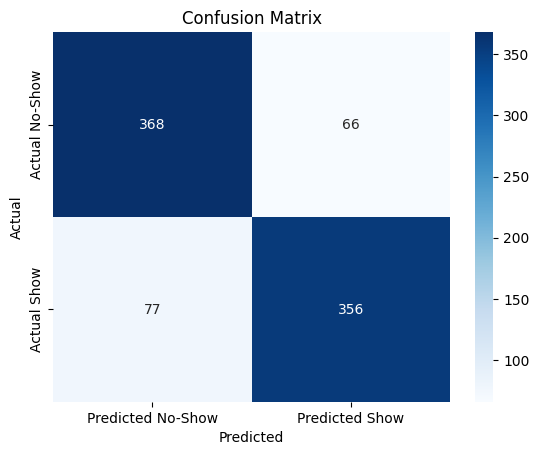

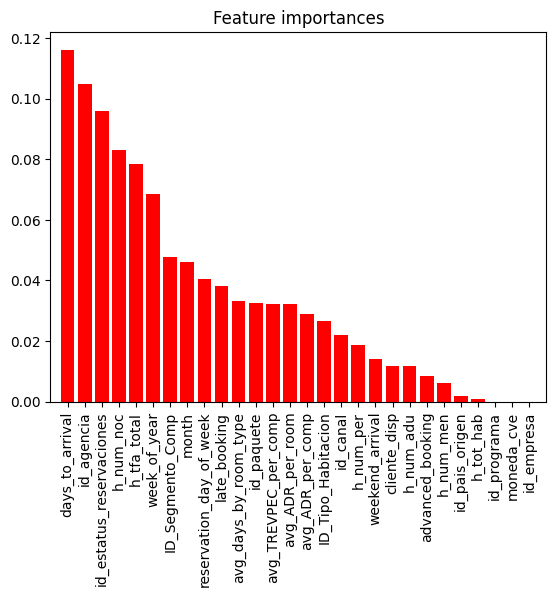

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a fitted pipeline
# Evaluate the pipeline on the test data
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Print the classification report
print(classification_report(y_test, y_pred))

# Generate and display a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted No-Show', 'Predicted Show'], yticklabels=['Actual No-Show', 'Actual Show'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance (for models that support this like RandomForest)
if 'RandomForestClassifier' in str(pipeline.named_steps['classifier']):
    importances = pipeline.named_steps['classifier'].feature_importances_
    features = X_train.columns
    indices = np.argsort(importances)[::-1]
    
    # Plot Feature Importance
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [44]:
selected_features = ['id_estatus_reservaciones','days_to_arrival','late_booking',
                        'reservation_day_of_week','id_paquete','ID_Segmento_Comp','week_of_year', 'h_tfa_total','month']

categorical_features = ['reservation_day_of_week', 'id_estatus_reservaciones',
                        'late_booking','id_paquete','ID_Segmento_Comp','month',
                        'week_of_year']


numerical_features = ['days_to_arrival', 'h_tfa_total']

In [45]:
# Pipeline para preprocesar
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Preprocesar los datos
X_preprocessed = preprocessor.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Entrenar modelo
model = RandomForestClassifier(random_state=42,  n_estimators=100, max_depth=10,max_features='sqrt',verbose=1)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.9s


Accuracy: 0.9845558894526824
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     39979
           1       0.10      0.00      0.00       619

    accuracy                           0.98     40598
   macro avg       0.54      0.50      0.50     40598
weighted avg       0.97      0.98      0.98     40598



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


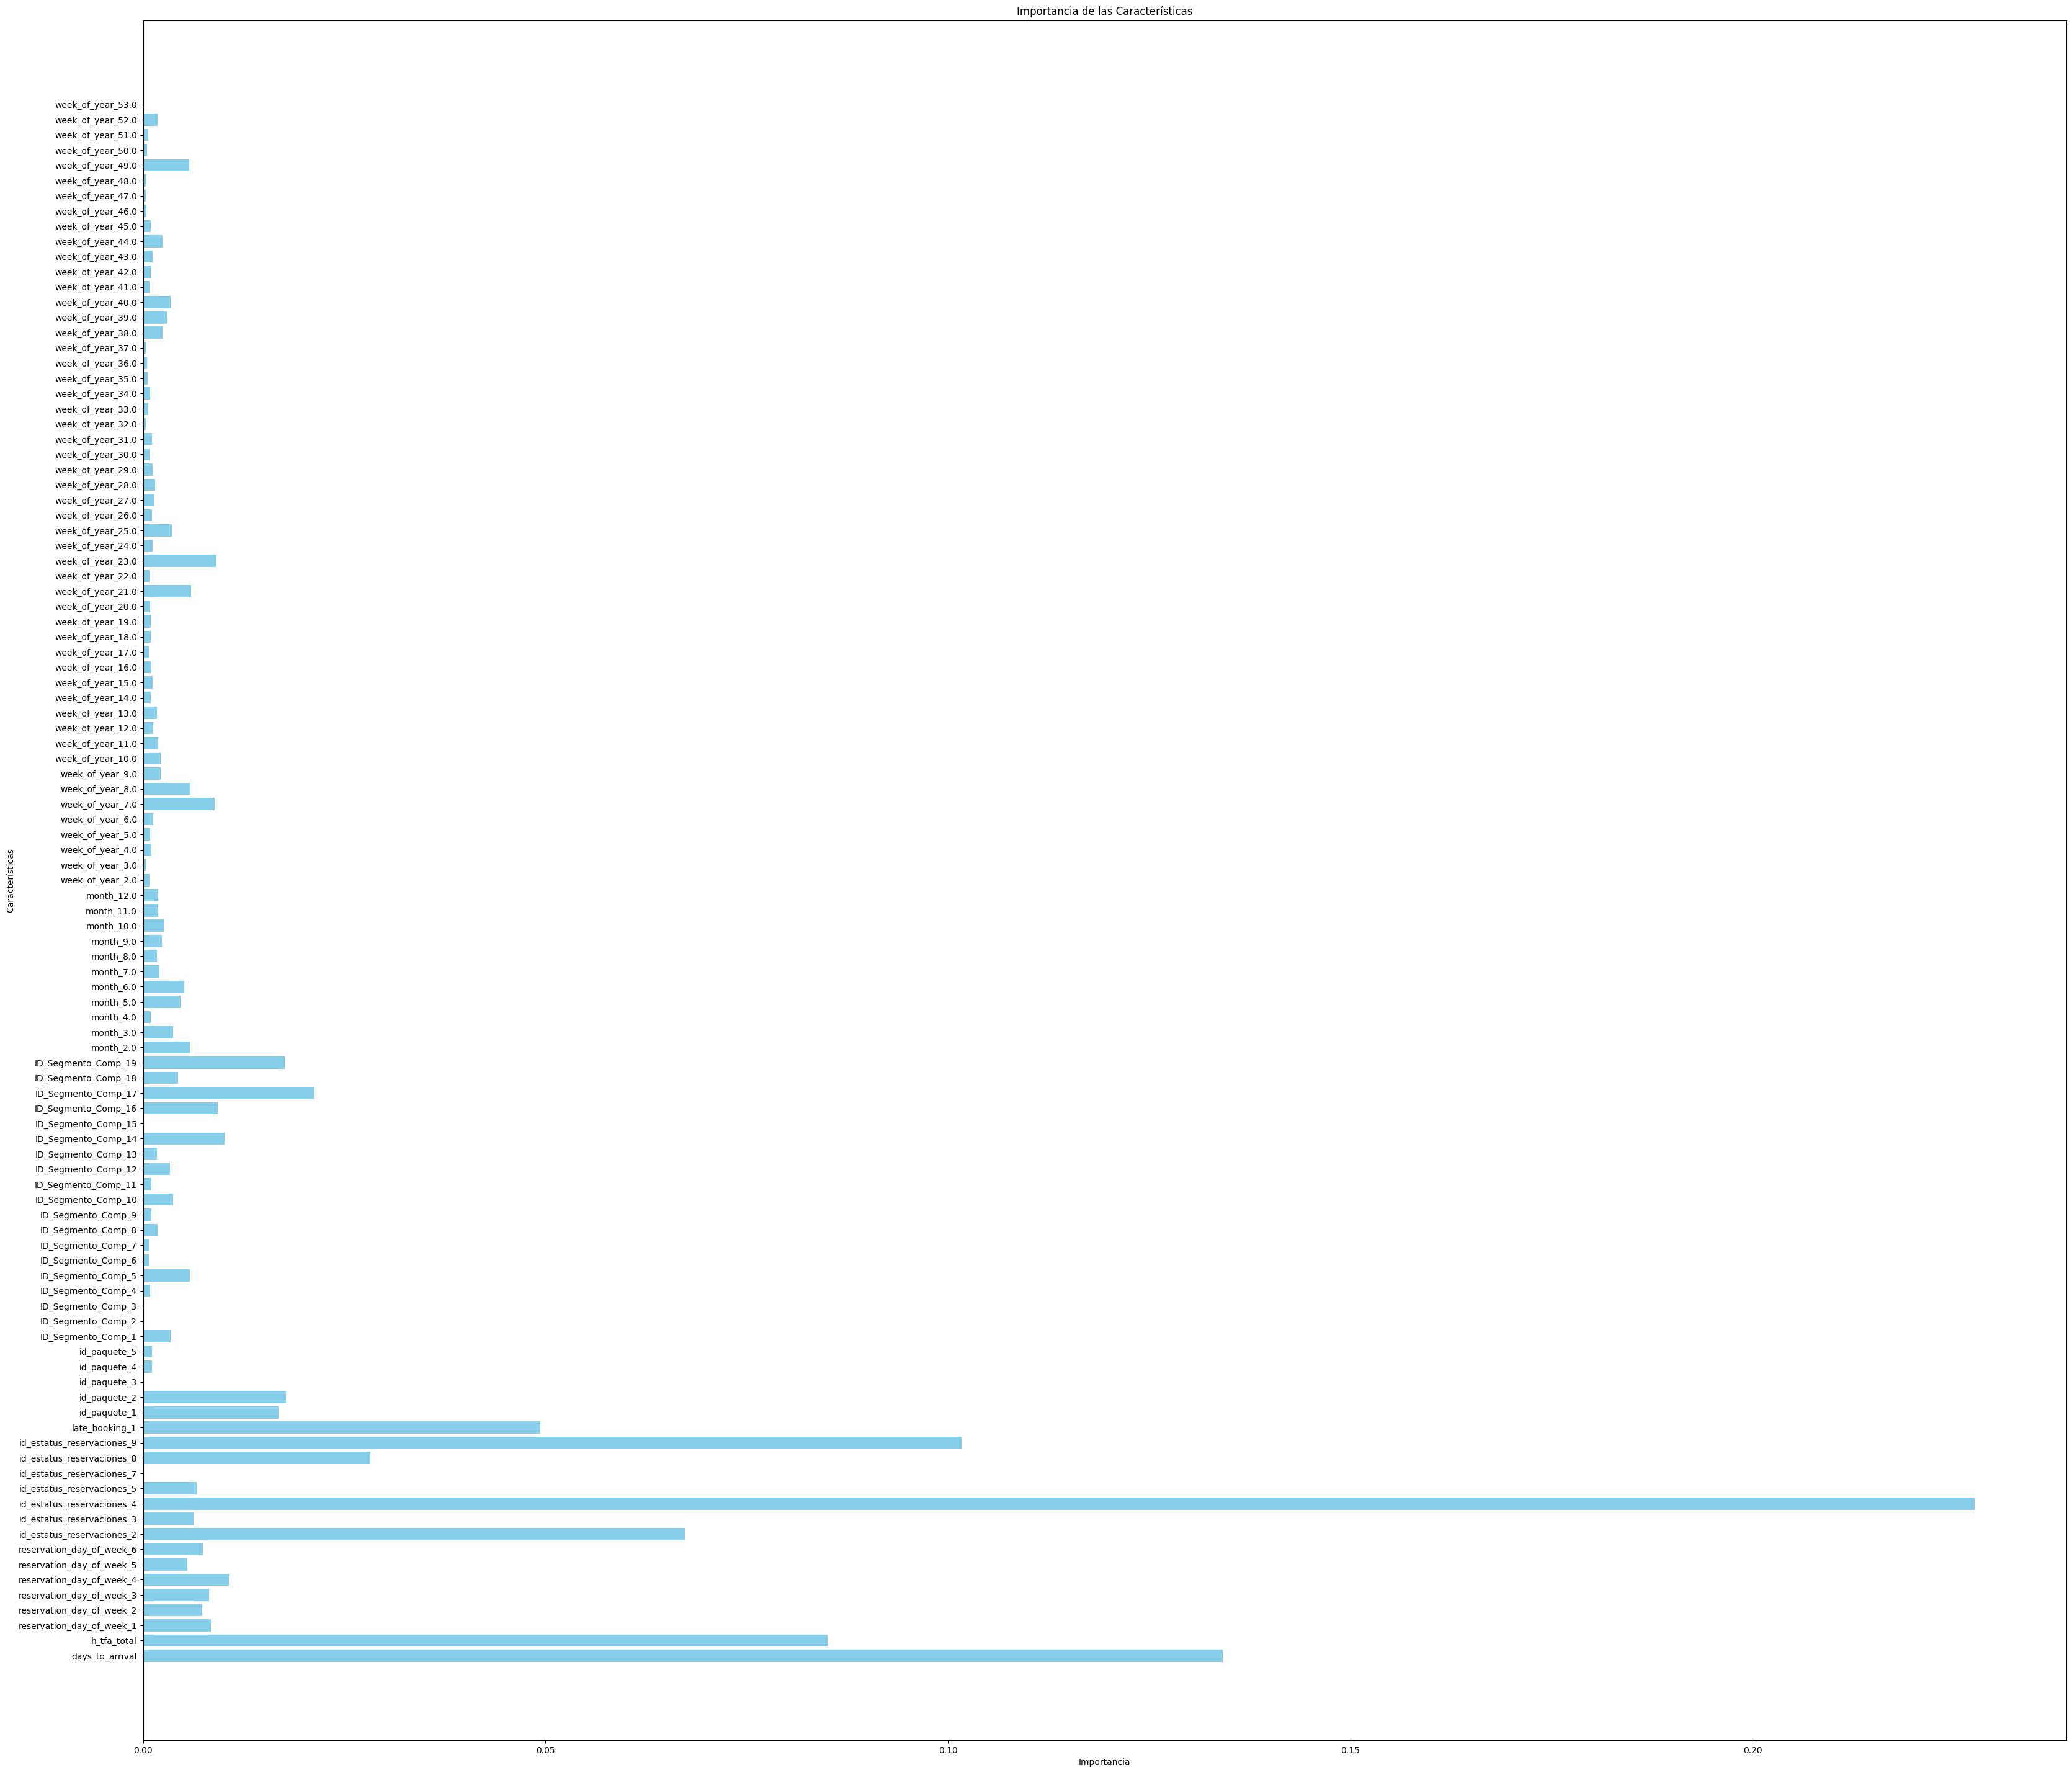

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener importancias de características
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
importances = model.feature_importances_

# Crear gráfico
plt.figure(figsize=(40, 36))
plt.barh(feature_names, importances, color='skyblue')
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

## REDES NEURONALES

In [48]:
df_reservaciones = df_resv

In [49]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Supongamos que df es tu DataFrame

# Mezclar los datos
df_reservaciones = shuffle(df_resv, random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba con estratificación
X = df_reservaciones[['days_to_arrival', 'id_agencia', 'id_estatus_reservaciones','h_num_noc',
                     'h_tfa_total', 'week_of_year','ID_Segmento_Comp', 'reservation_day_of_week','late_booking']]  # Asume que 'reservacion' es tu columna objetivo
y = df_reservaciones['is_no_show']





In [50]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the undersampler
rus = RandomUnderSampler( random_state=42)

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the balance
print(pd.Series(y_resampled).value_counts())  # Outputs the counts of each class to confirm balance


is_no_show
0    2167
1    2167
Name: count, dtype: int64


In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,  # This should match y_resampled
    random_state=42
)

# Verify class distribution in the train and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Test set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
is_no_show
1    0.500144
0    0.499856
Name: proportion, dtype: float64
Test set class distribution:
is_no_show
0    0.500577
1    0.499423
Name: proportion, dtype: float64


In [52]:
from keras.models import Sequential
model = Sequential()
model.add(Dense(10, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [92]:
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(10, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=0.0001)  # Test different rates
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [93]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2)
model.summary()
     

Epoch 1/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5233 - loss: 223.0383 - val_accuracy: 0.4726 - val_loss: 143.2878
Epoch 2/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5050 - loss: 101.2872 - val_accuracy: 0.4697 - val_loss: 24.5198
Epoch 3/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5033 - loss: 10.0708 - val_accuracy: 0.5043 - val_loss: 0.7964
Epoch 4/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5069 - loss: 1.1591 - val_accuracy: 0.5101 - val_loss: 0.7468
Epoch 5/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5078 - loss: 1.9233 - val_accuracy: 0.5620 - val_loss: 0.7594
Epoch 6/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4852 - loss: 1.0474 - val_accuracy: 0.5086 - val_loss: 0.7163
Epoch 7/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5133 - loss: 1.4410 - val_accuracy: 0.5360 - val_loss: 0.7028
Epoch 8/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4869 - loss: 1.7265 - val_accuracy: 0.

KeyboardInterrupt: 

In [78]:
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
Epochs = [i+1 for i in range(len(tr_loss))]
loss_label = f'best epoch= {str(index_loss + 1)}'
val_lowest

0.5584807991981506

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2 Score= -0.259517246517172
Accurcy= 0.6851211072664359


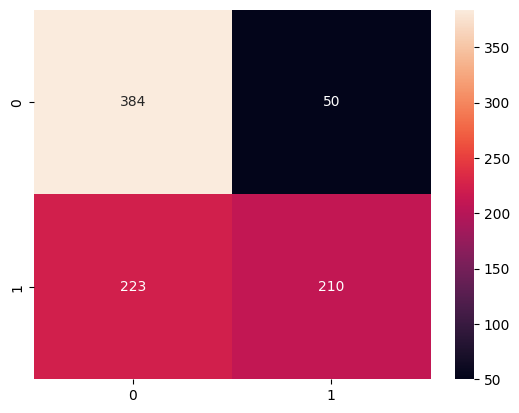

In [79]:
from sklearn.metrics import r2_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)

R2 = r2_score(y_test, y_pred)
print("R2 Score=",R2 )
Accurcy = accuracy_score(y_test, y_pred)
print("Accurcy=",Accurcy )


conf_matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix,annot=True, fmt='d')
plt.show()
     

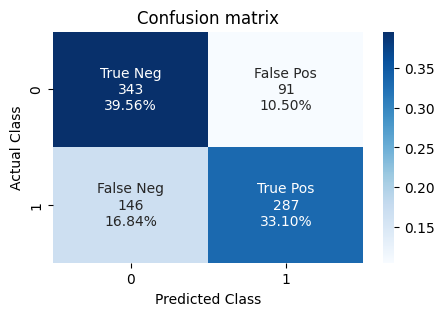

In [70]:
# Define a function to plot the confusion matrix as a heatmap
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2 , v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.subplots(figsize = (5,3))
    ax = sns.heatmap(cm/np.sum(cm), annot=labels, fmt="", cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    ax.set_title(f'Confusion matrix')
    plt.show()
    
    
    
# Plot the confusion matrix as a heatmap
plot_confusion_matrix(y_test, y_pred)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
AUC Score= 0.7722219857174786
Accuracy= 0.726643598615917


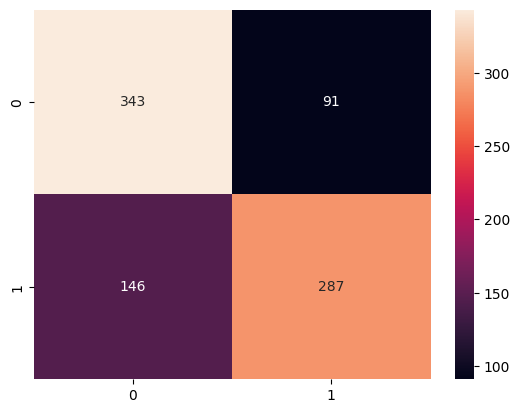

In [69]:
from sklearn.metrics import roc_auc_score

# Use model.predict() to get the prediction probabilities for the positive class
y_probs = model.predict(X_test)  # This assumes the output is the probability of the positive class

# If your model outputs a probability in a different format, adjust indices accordingly
# For example, if it's multi-class classification, you might need to select a specific column:
# y_probs = model.predict(X_test)[:, 1]  # Assuming the second column is for class '1'

# Compute AUC
auc = roc_auc_score(y_test, y_probs)
print("AUC Score=", auc)


Accuracy = accuracy_score(y_test, (y_probs > 0.5).astype(int))
print("Accuracy=", Accuracy)

conf_matrix = confusion_matrix(y_test, (y_probs > 0.5).astype(int))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()


In [71]:
# Directly using y_pred as probabilities if they represent the probability of the positive class
auc = roc_auc_score(y_test, y_pred.astype(float))  # Ensure it's float for AUC computation
print("AUC Score=", auc)


AUC Score= 0.7265700663041049


## parameter tuning

In [75]:
!pip install keras-tuner --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [74]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from kerastuner import Objective
import keras_tuner as kt

ModuleNotFoundError: No module named 'kerastuner'

In [95]:
from keras_tuner import RandomSearch
from keras.models import Sequential
from keras.layers import Dense

# Define the hypermodel
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_layer1', min_value=8, max_value=64, step=8),
                    activation=hp.Choice('activation_layer1', ['relu', 'tanh'])))
    for i in range(hp.Int('num_layers', 1, 4)):  # Tune the number of layers
        model.add(Dense(hp.Int(f'units_layer{i+2}', min_value=8, max_value=64, step=8),
                        activation=hp.Choice(f'activation_layer{i+2}', ['relu', 'tanh'])))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='tuning_results',
    project_name='tune_nn'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=200, validation_split=0.2, verbose=1)


Trial 20 Complete [00h 00m 30s]
val_accuracy: 0.5561959743499756

Best val_accuracy So Far: 0.7492795586585999
Total elapsed time: 00h 06m 41s


In [98]:
print(X_train.shape)  # Should be (num_samples, num_features)


(3467, 9)


In [106]:
from keras.models import Sequential
from keras.layers import Dense
from keras_tuner import Hyperband

def build_model(hp):
    model = Sequential()
    # Define the input shape in the first layer
    model.add(Dense(
        units=hp.Int('units_layer1', min_value=8, max_value=64, step=8),
        activation=hp.Choice('activation_layer1', ['relu', 'tanh']),
        input_dim=X_train.shape[1]  # Define input shape here
    ))
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(
            units=hp.Int(f'units_layer{i+2}', min_value=8, max_value=64, step=8),
            activation=hp.Choice(f'activation_layer{i+2}', ['relu', 'tanh'])
        ))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss="binary_crossentropy",
        metrics=['accuracy']
    )
    return model


In [107]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Force the model to build with dummy input
model.build(input_shape=(None, X_train.shape[1]))

# Print the summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 56)             │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,273 (16.69 KB)

 Trainable params: 4,273 (16.69 KB)

 Non-trainable params: 0 (0.00 B)

In [156]:
def build_model(hp):
    model_tuner = Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model_tuner.add(Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
    model_tuner.add(Dense(1, activation='sigmoid'))
    model_tuner.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model_tuner


tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=2,
    directory='my_dir',
    project_name='churn_classification')


tuner.search_space_summary()

Reloading Tuner from my_dir\churn_classification\tuner0.json
Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [157]:
tuner.search(X_train, y_train, epochs=500, validation_split=0.2)
     

In [158]:
best_model = tuner.get_best_models(num_models=1)[0]
input_shape = X_train.shape[1:]
best_model.build(input_shape=(None, *input_shape))
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 480)            │       123,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        15,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,209 (571.13 KB)

 Trainable params: 146,209 (571.13 KB)

 Non-trainable params: 0 (0.00 B)

In [159]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6267 - loss: 1.4200
Test Accuracy: 0.6574394702911377


In [160]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5)
     


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [161]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.657439446366782
[[322 112]
 [185 248]]
              precision    recall  f1-score   support

           0       0.64      0.74      0.68       434
           1       0.69      0.57      0.63       433

    accuracy                           0.66       867
   macro avg       0.66      0.66      0.65       867
weighted avg       0.66      0.66      0.65       867



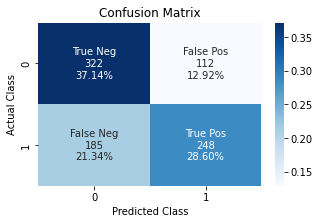

In [162]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2 , v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.subplots(figsize = (5,3))
    ax = sns.heatmap(cm/np.sum(cm), annot=labels, fmt="", cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    ax.set_title(f'Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred)